# Final Capstone

### Processing and Optical Character Recognition (OCR) for full document.

### DA 1506

This form (shown below) is a picture of a DA Form 1506, which is the form that I am trying to process and pull data from. It's an interesting issue, due to the nature of the fonts, location of data, and structure of the document. The data is as follows:

- Block 1: Name of individual
- Block 2: Their Identification Number
- Block 3: Their current assigned unit.
- Block 4: Periods of Service (note: continuation sheet (1506-1) for more thatn 14 rows).


![1506](../Example.png)

In most cases, this document will be saved as a png, jpg, or tiff, and also has various versions that I will need to account for in the future, but the data should be in similar locations. The document fonts, size, and words are strictly enforced by policy, so I shouldn't have to worry to much about wierd values.

The data that I am most interested in processing is the Periods of Service. Extracting each row into a Dataframe would be a fantastic "final product". The biggest hurdle will not be the modeling for OCR, but actually just preparing and processing the image for the models to extract the data from.

In [29]:
%%capture
%pip install opencv-python
%pip install pytesseract
%pip install PyMuPDF
%pip install pyocr
%pip install torch torchvision torchaudio
%pip install easyocr

# I will need to use both PIL and cv2 for different models/reasons. I like them both =] 
from PIL import Image
from IPython.display import Image as Img
import cv2

# Gotta have these for working with the numbers
import numpy as np
import pandas as pd

# Working with the pdfs (might not use them all)
import glob, sys, fitz

# Showing the images in the notebook as opposed to opening files.
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

# OCR Models
import pytesseract

import pyocr
import pyocr.builders  
tools = pyocr.get_available_tools()
tool = tools[0]

import easyocr
reader = easyocr.Reader(['en'])

### Pdf to Image

I'd like to convert the page of the 1506 into a image. This fitz library is fantastic. The loop isn't necessary now, but I am keeping it for simplicity sake if I choose to change my pdf forms later.

In [43]:
# To get better resolution
zoom_x = 2.0  # horizontal zoom
zoom_y = 2.0  # vertical zoom
mat = fitz.Matrix(zoom_x, zoom_y)  # zoom factor 2 in each dimension

form = 'form-2'

doc = fitz.open(f'../forms/{form}.pdf')  # open document

for page in doc:
    pix = page.get_pixmap(matrix=mat)  # render page to an image
    pix.save(f"images/01. {form}-page-%i.png" % (page.number + 1))  # store image as a PNG
    
# Read the image
img = cv2.imread(f'images/01. {form}-page-1.png', 0) 

We've got a nice, quality image now to work with. The next steps for processing will be to locate the key elements of the document. I'm going to skip the Name, DoD, and Address elements, as they are out of the scope of my work. The 4th block, "Period of Service" is what I will be targeting. 

In order to ensure that I am working with a good image size, I'm going to "zoom" into the black lines of the document and remove the margins that might vary from print-to-scan. The output of this image inverted in matplotlib doesn't show it exactly as it is; the real image when used (img_bin) is actually black and white, with zero other color.

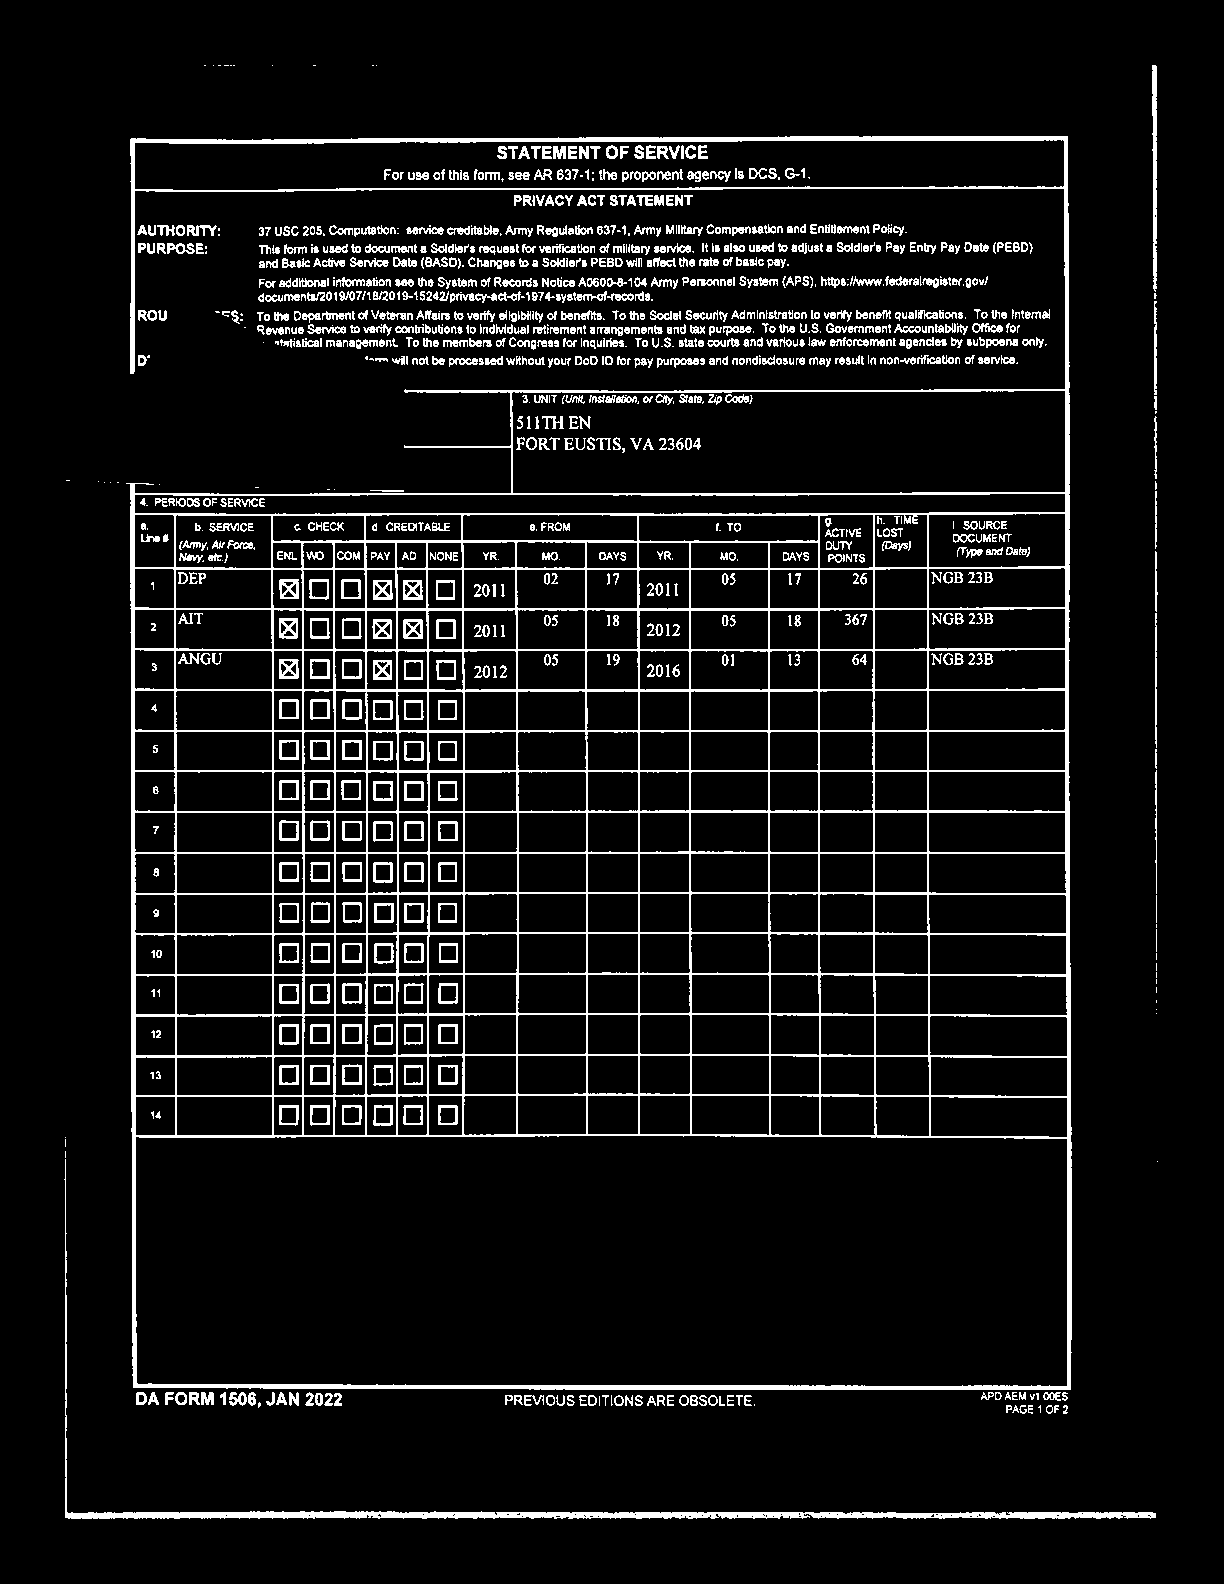

In [44]:
# Thresholding the image
(thresh, img_bin) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
# Invert the image
img_bin = 255-img_bin

cv2.imwrite(f"images/02. {form}-img_bin.png", img_bin)

Img(filename=f'images/02. {form}-img_bin.png')

Now that the image is threshed and inverted, we can locate the form's vertical/horizontal lines that create the sections and blocks of the document.

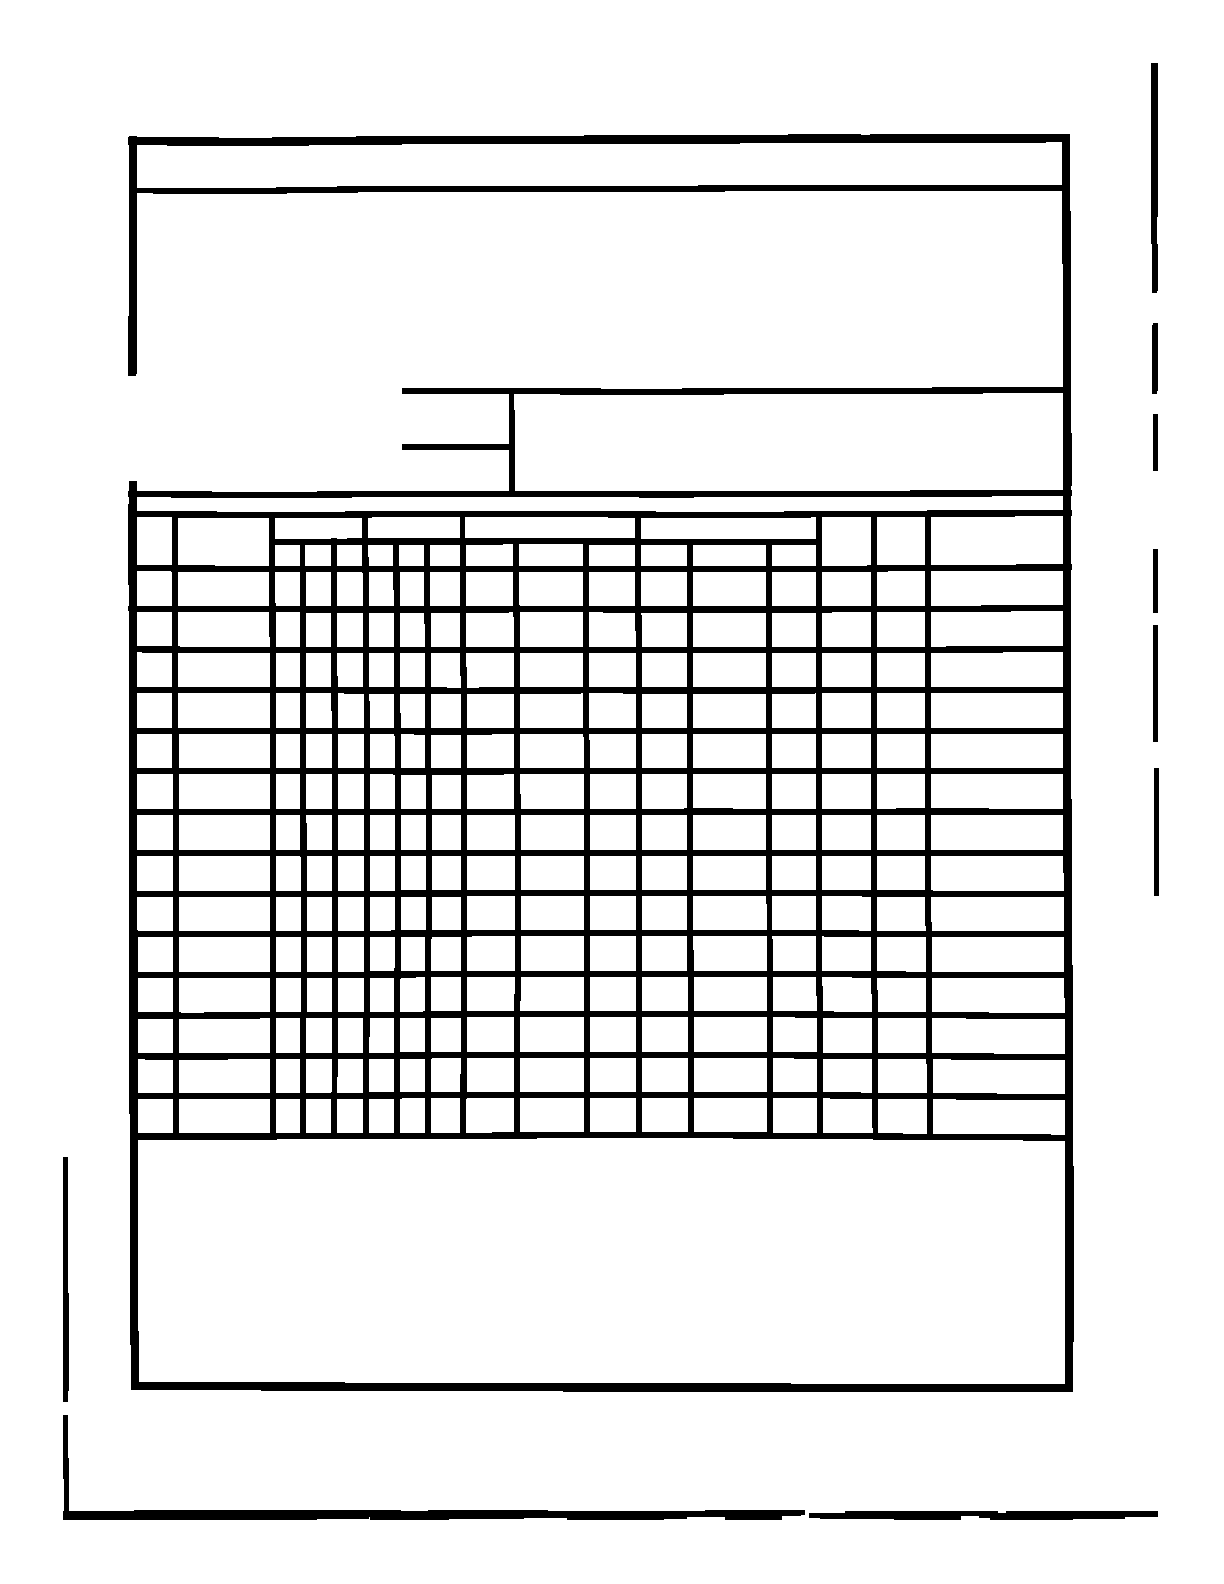

In [45]:
# Defining a kernel length
kernel_length = np.array(img).shape[1] // 80
 
# Verticle kernel of (1 X kernel_length)
# > detects all the verticle lines from the image.

# Horizontal kernel of (kernel_length X 1)
# > detects all the horizontal line from the image.
verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))

# A kernel of (3 X 3) ones.
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

# Morphological operation to detect vertical lines from an image
img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations= 3 )
verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations = 3)

# Morphological operation to detect horizontal lines from an image
img_temp2 = cv2.erode(img_bin, hori_kernel, iterations = 3)
horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)

# Weighting parameters, this will decide the quantity of an image to be added to make a new image.
alpha = 0.5
beta = 1.0 - alpha
# This function helps to add two image with specific weight 
# parameter to get a third image as summation of two image.
img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
(thresh, img_final_bin) = cv2.threshold(img_final_bin, 128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

cv2.imwrite(f"images/03. {form}-img_final_bin.png", img_final_bin)

# Show the image
Img(filename=f"images/03. {form}-img_final_bin.png")

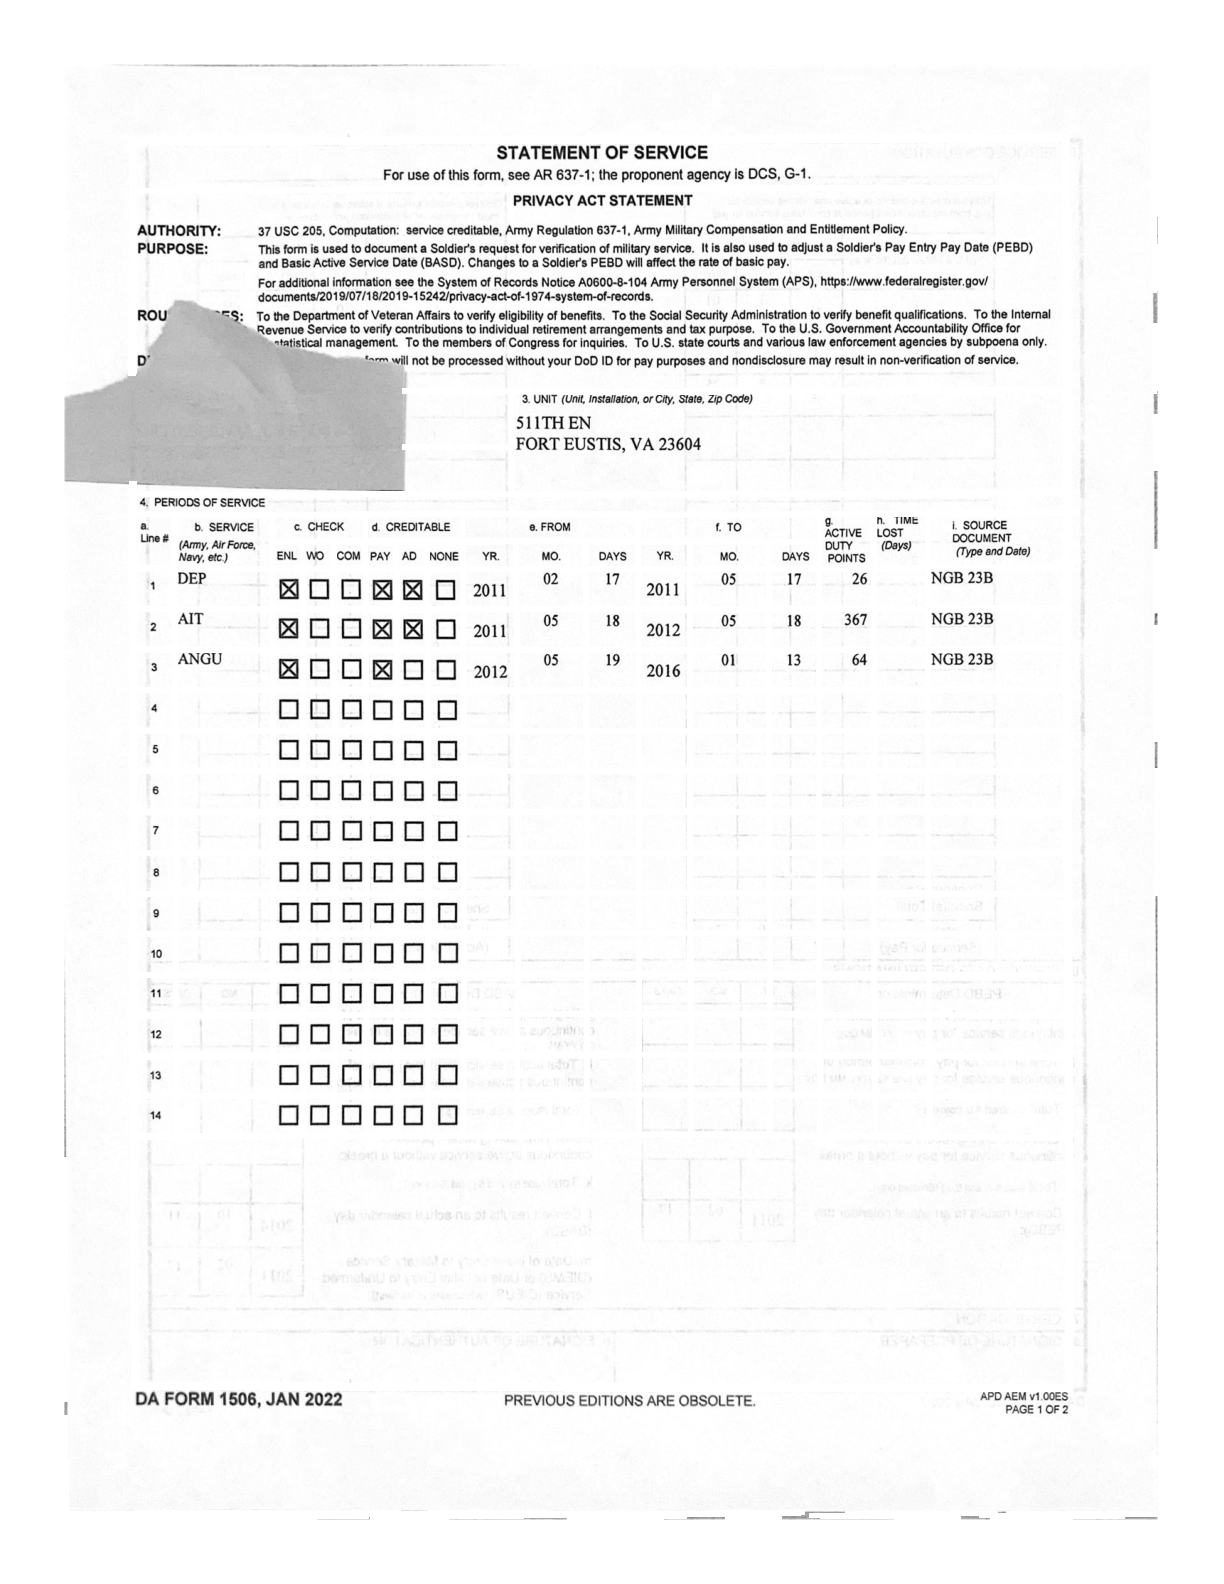

In [46]:
# Blending img1 and img2 together.
img1 = cv2.imread(f'images/01. {form}-page-1.png', 0)
img2 = cv2.imread(f'images/03. {form}-img_final_bin.png', 0)

invert = cv2.bitwise_not(img2)
dst = cv2.addWeighted(img1, 1, invert, 1, 0)

cv2.imwrite(f"images/04. {form}-blended.png", dst)

Img(filename=f'images/04. {form}-blended.png')

Now, I want to locate and zoom in on the periods of service. From this point on, I will be using three different models to perform the same tasks as a way of noting the strength and weakness of each. It will also help fill the gaps if models miss information. However, location of text with pytesseract is really easy and convenient, because I can map the results into a dataframe and using pandas for sorting and such.

In [47]:
img = cv2.imread(f'images/04. {form}-blended.png', 0)

# Need this for cropping the image down later.
height, width = img.shape

# Tesseract
results = pytesseract.image_to_data(img, lang='eng', output_type='data.frame')
results.dropna().head()

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
4,5,1,1,1,1,1,497,146,104,14,95.651939,STATEMENT
5,5,1,1,1,1,2,606,145,23,14,96.436424,OF
6,5,1,1,1,1,3,634,145,74,14,96.497879,SERVICE
10,5,1,2,1,1,1,384,169,20,11,96.989639,For
11,5,1,2,1,1,2,408,172,21,8,95.684380,use


Since the text will only be a single word, I will look for it using the word "PERIODS" (case sensitive) which is the only instance in the document.

In [48]:
results[results['text'] == 'PERIODS']

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
189,5,1,13,1,1,2,155,498,45,9,91.078979,PERIODS


Now, I'm going to crop away the top of the page to just get me the Periods of Service block down.

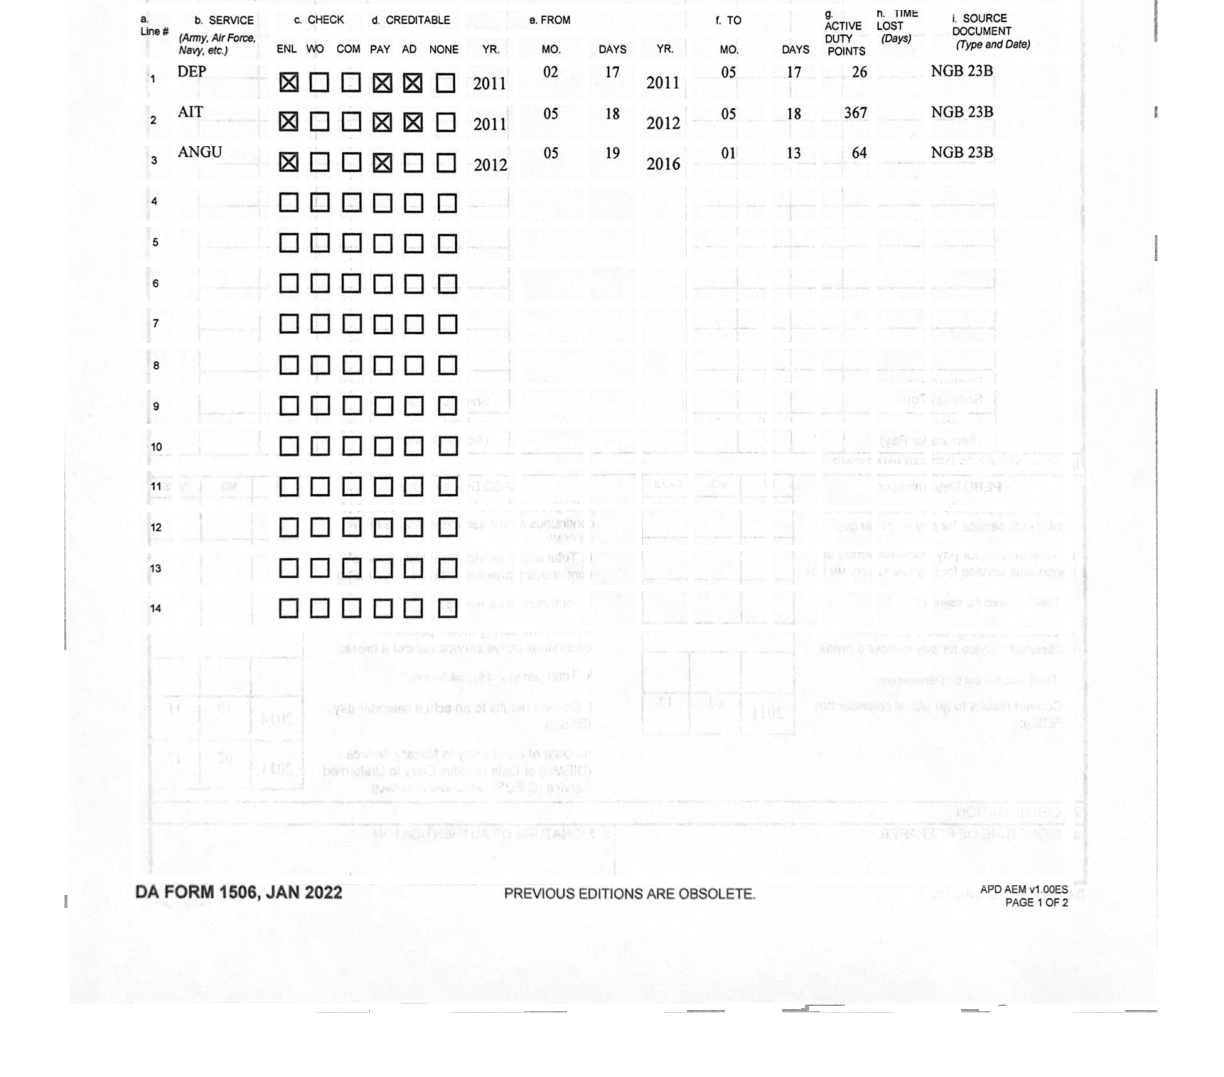

In [49]:
img = cv2.imread(f'images/04. {form}-blended.png', 0)

text = 'PERIODS'

# Getting the location for "Period of Service"
y = results[results['text'] == text]['top'].iloc[0]
h = results[results['text'] == text]['height'].iloc[0]

crop_img = img[y+h:height, 0:width]
cv2.imwrite(f"images/05. {form}-blended_cropped.png", crop_img)

Img(filename=f"images/05. {form}-blended_cropped.png")

Using another key word "POINTS" I can zoom to the first row. This process isn't clever and needs a lot of work, but it's functioning now, so I will clean it up later in the pipeline.

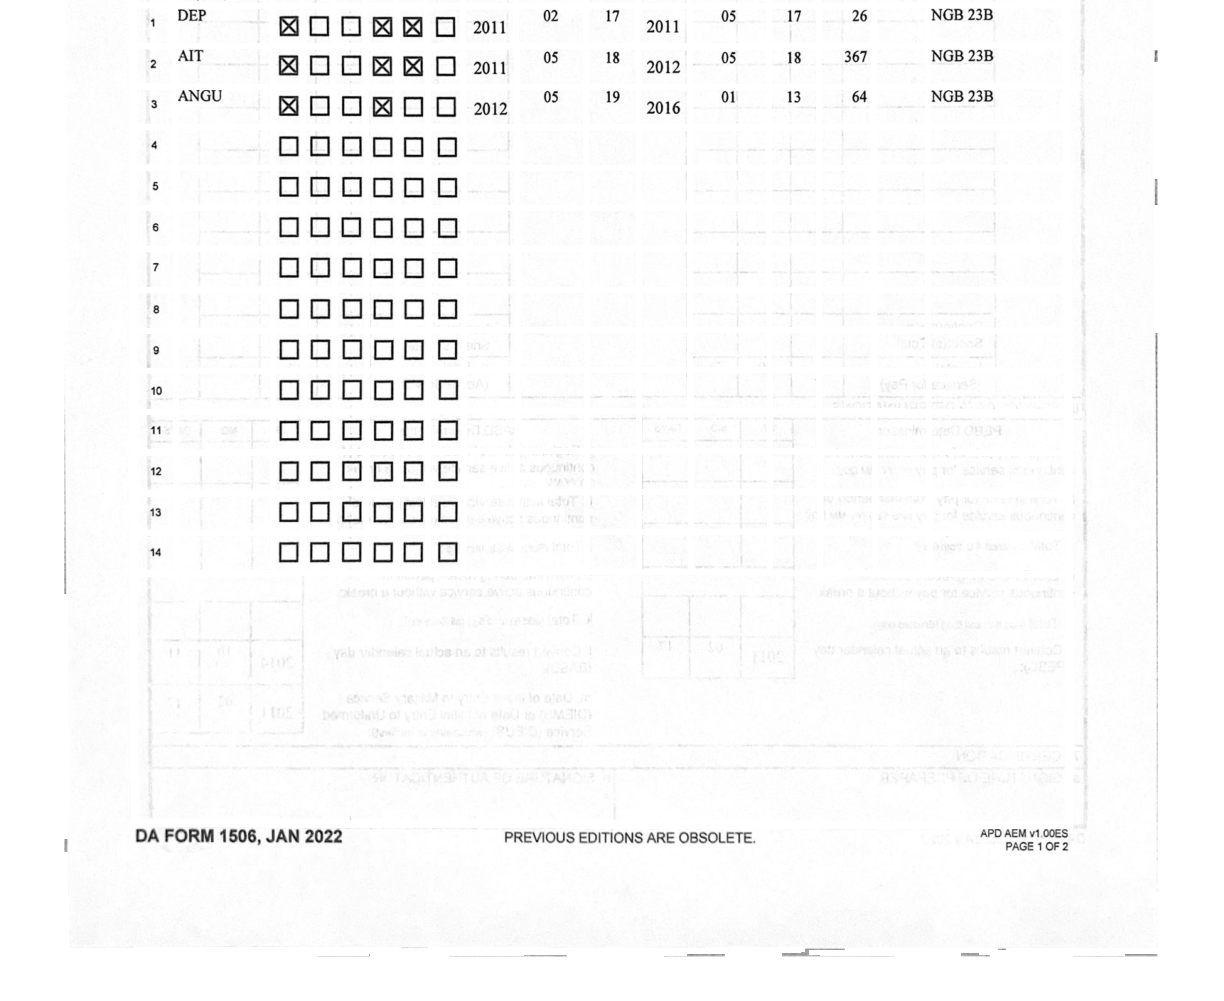

In [50]:
img = cv2.imread(f"images/05. {form}-blended_cropped.png", 0)
results = pytesseract.image_to_data(img, lang='eng', output_type='data.frame')

y = results[results['text'] == 'POINTS']['top'].iloc[0]
h = results[results['text'] == 'POINTS']['height'].iloc[0]
    
height, width = img.shape

crop_img = img[y+h:height-20, 0:width] # << I added some buffer to make it a little cleaner.
cv2.imwrite(f"images/06. {form}-periods.png", crop_img)

Img(filename=f"images/06. {form}-periods.png")

### Summary

I can continue to process the images later in the pipeline. Right now, I am able to get the correct section of the document for processing, so now I have to finish the processing.

Next steps:
- Extract table as cells
- Infer text from the cells and pass into a dataframe.
- Figure out how to process the check boxes.